In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline 

In [28]:
from dpdl_defaults import *
import viz_utils
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes
from sklearn.model_selection import train_test_split
from midog_dataset import SlideContainer, MIDOGTrainDataset, custom_sampling_fun
import numpy as np
import albumentations as A
import os.path
import json

In [3]:
seed = 31415
np.random.seed(seed)
torch.manual_seed(seed)
seed_for_datasplit = seed

categories = [1]
patchsize = 512
batchsize = 12

list_image_filenames = TRAINING_IDS

In [4]:
# load annotations
annotation_json = os.path.join(MIDOG_DEFAULT_PATH, MIDOG_JSON_FILE)
with open(annotation_json) as f:
    annotation_data = json.load(f)

# Show some examples on the full slide
anno_dict = {1: "mitotic figure", 2: "impostor"}


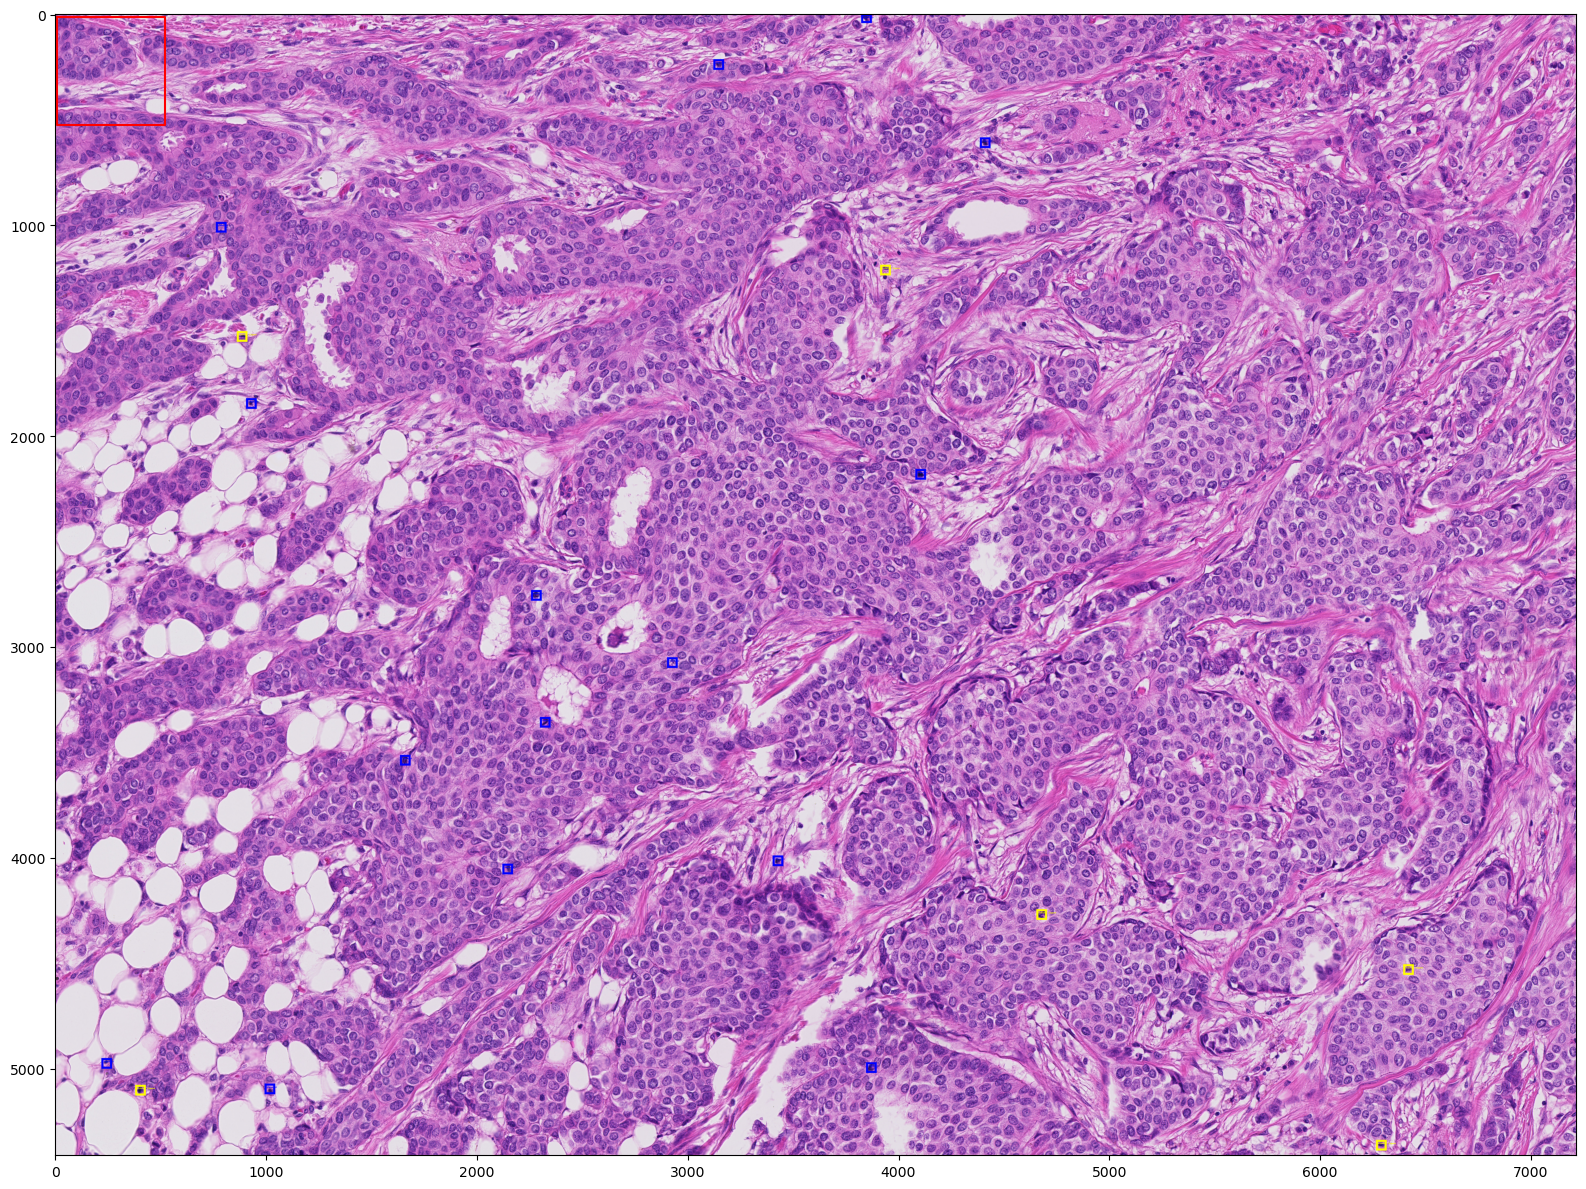

In [5]:
list_idx = 4  # note: this is just (!) the entry in the list but not slide id

image, target_dict = viz_utils.get_image_and_bboxes(TRAINING_IDS[list_idx], annotation_data)
labels_str = [anno_dict[l] for l in target_dict["labels"]]

# yellow: mitotic figure, blue: impostor
colors = viz_utils.get_colors_for_labels(target_dict["labels"])
annotated_image = draw_bounding_boxes(torch.from_numpy(image.transpose(2, 0, 1)), 
    torch.from_numpy(target_dict["boxes"]), labels=labels_str, colors=colors, width=10)

# where we want to show the full RoI extracted from the whole slide image
fig, ax = plt.subplots(figsize=(20, 12), dpi=100)
ax.imshow(annotated_image.permute(1, 2, 0).numpy())
ax.plot([10, 522, 522, 10, 10], [10, 10, 522, 522, 10], color="red")
# ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fig.tight_layout()
fig.show()

In [76]:
slide_folder = MIDOG_DEFAULT_PATH
res_level = 0  # work at original resolution
containers = []
for image_filename in list_image_filenames:
    # filter annotations by image_id and desired annotation type
    bboxes, labels = viz_utils.get_bboxes(image_filename, annotation_data, categories)
    
    # "categories" selection some bboxes are empty (no annotations)--> need to skip them
    if len(bboxes)==0:
        continue
    
    image_id = viz_utils.image_filename2id(image_filename)
    containers.append(SlideContainer(os.path.join(slide_folder, image_filename), image_id, y=[bboxes, labels], 
                                    level=res_level, width=patchsize, height=patchsize, sample_func = custom_sampling_fun))

In [77]:
# split the train set into train and validation
train_containers, val_containers = train_test_split(containers, train_size=0.8, random_state=seed_for_datasplit)

tfms = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.1, p=0.5)
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [81]:
containers[1].targets

[array([[2211,  740, 2261,  790],
        [ 349,  307,  399,  357],
        [4247, 2827, 4297, 2877]]),
 array([1, 1, 1])]

In [82]:
first, second = val_dataset[2]
second

{'boxes': tensor([[280., 188., 330., 238.]]),
 'labels': tensor([1]),
 'image_id': tensor([36]),
 'iscrowd': tensor([0]),
 'area': tensor([2500.])}

In [83]:
num_patches_train = 10
num_patches_val = 1

dataset = MIDOGTrainDataset(train_containers, patches_per_slide_container=num_patches_train,
                            transform=tfms, sample_func = custom_sampling_fun)
val_dataset = MIDOGTrainDataset(val_containers, patches_per_slide_container=num_patches_val,
                                transform=tfms, sample_func = custom_sampling_fun)

data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batchsize, shuffle=True, num_workers=0, collate_fn=viz_utils.collate_fn)

val_data_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batchsize, shuffle=False, num_workers=0, collate_fn=viz_utils.collate_fn)


In [86]:
# print('\n'.join([f"{i}, {c.image_id}" for i, c in enumerate(containers)]))

# image file is truncated (3884 bytes not processed) for region (1819, 1535, 512, 512) for image with dimensions (6214, 4644) 
# /home/janus/iwb6-datasets/MIDOG2021/158.tiff) --> 125
con = containers[-1]
print(con.image_id)
print(con.slide_shape)
con.get_patch(1819, 1535).shape

150
(6467, 4862)


(512, 512, 3)

In [51]:
# visualize some training & validation images
print("Some stats:\n" +
      "Length of the train set:      {}\n".format(len(dataset)/num_patches_train) +
      "Length of the validation set: {}\n".format(len(val_dataset)/num_patches_val))

# Note how many times you have to execute this cell (before implementing the improved sampling strategy)
# to get examples with mitotic figures (with a yellow bounding box). The detection problem is severely imbalanced.

Some stats:
Length of the train set:      95.0
Length of the validation set: 24.0



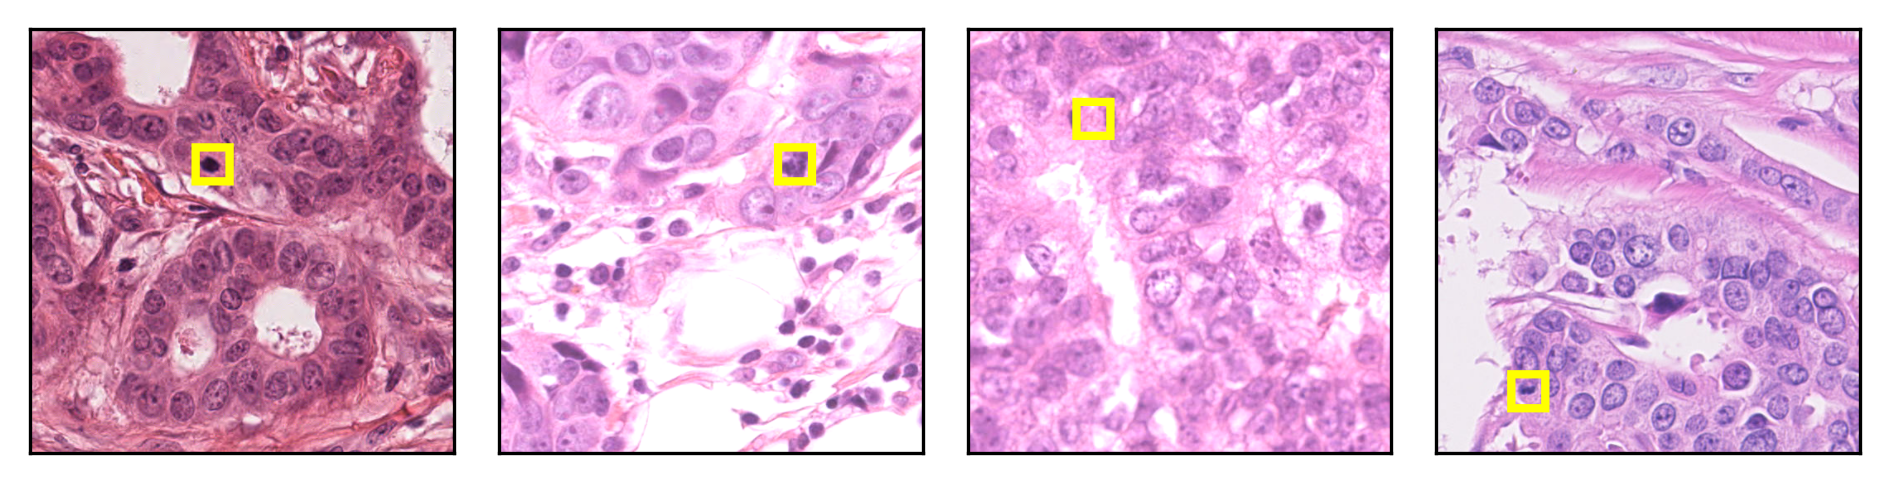

In [90]:
num_examples = 4
fig, ax = plt.subplots(1, num_examples, dpi=300)
for i in range(num_examples):
      images, targets = dataset[i]  # exchange to see sth from the val_dataset
      annotated_image = draw_bounding_boxes((images*255).to(torch.uint8), targets["boxes"], colors="yellow", width=10)
      ax[i].imshow(annotated_image.permute(1, 2, 0).numpy())
      ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fig.tight_layout()
fig.show()

Note: loading pretrained weights does not work on jupyter notebooks. To execute the following cells, execute the following lines in a command line on the cluster (with the seminar_dpdl environment activated):
```bash
python
import torchvision.models.detection
model = torchvision.models.detection.retinanet_resnet50_fpn_v2(weights='DEFAULT')
exit()
```

This pre-downloads the weights sucht that they are also available within the jupyter notebook. Typically, this only has to be done once.


In [94]:
torch.cuda.device_count()

0

In [9]:
import torchvision.models.detection

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torchvision.models.detection.retinanet_resnet50_fpn_v2(weights='DEFAULT')  
num_classes = 2  # 1 class (mitotic figure) + background

in_features = model.backbone.out_channels
model.head = torchvision.models.detection.retinanet.RetinaNetHead(in_features, model.anchor_generator.num_anchors_per_location()[0], num_classes)
print("Number of output features of the backbone: {}".format(in_features))

Number of output features of the backbone: 256


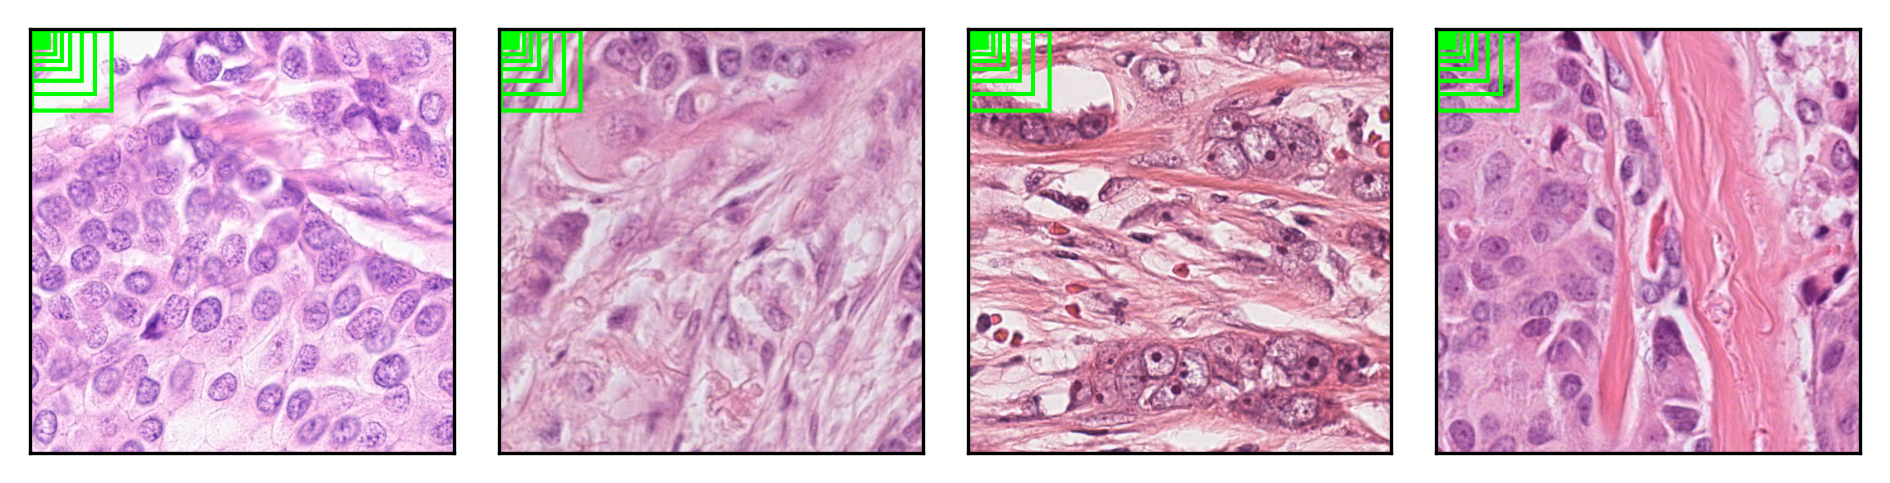

In [10]:
# visualization of anchors:
from network import MyRetinaModel
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.retinanet import _default_anchorgen

# generate a model
num_classes = 2
lr = 2e-4
num_epochs = 50
my_detection_model = MyRetinaModel(num_classes=2, iterations_epoch=len(data_loader), lr=lr, epochs=50)

# show the anchors that are used for object detection (ground truths for mitotic figures in yellow, anchors in lime green)
anchors = AnchorGenerator().generate_anchors(my_detection_model.sizes, my_detection_model.ratios)

anchors = anchors - torch.min(anchors, dim=1, keepdim=True)[0]  # make sure that begin at (0, 0)
num_examples = 4
fig, ax = plt.subplots(1, num_examples, dpi=300)
for i in range(num_examples):
      images, targets = dataset[i]
      colors = ["yellow"] * len(targets["boxes"]) + ["lime"] * len(anchors)
      annotated_image = draw_bounding_boxes((images*255).to(torch.uint8), torch.cat((targets["boxes"], anchors)), colors=colors, width=5)
      ax[i].imshow(annotated_image.permute(1, 2, 0).numpy())
      ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fig.tight_layout()
fig.show()